## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download video

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/uas_ml_road_sign/sample_video2.mp4"

## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **23.01.2023** with version **YOLOv8.0.17**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

In [ ]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.2/107.7 GB disk)


## Install ByteTrack

[ByteTrack](https://github.com/ifzhang/ByteTrack) is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with [YOLOv8](https://github.com/ultralytics/ultralytics).

## Install Roboflow Supervision

In [ ]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.21.0


## Load pre-trained YOLOv8 model

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/uas_ml_road_sign/model2.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/uas_ml_road_sign/model2.zip
   creating: runs/detect/train4/weights/
  inflating: runs/detect/train4/weights/last.pt  
  inflating: runs/detect/train4/weights/best.pt  


In [ ]:
# settings
MODEL = "runs/detect/train4/weights/best.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11127519 parameters, 0 gradients, 28.4 GFLOPs


In [ ]:
model.model.names

{0: 'bus', 1: 'car', 2: 'motorcycle', 3: 'person', 4: 'truck'}

## Predict and annotate single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest
selected_classes = [0,1,2,3,4]

In [ ]:
import supervision as sv
import numpy as np

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


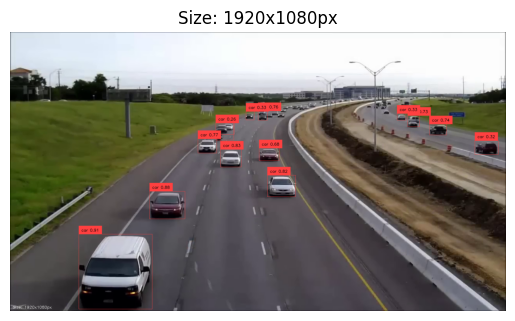

In [ ]:
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt
import cv2

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.5)

# acquire first video frame
iterator = iter(generator)
frame = next(iterator)

# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes defined above
detections = detections[np.isin(detections.class_id, selected_classes)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate frame
annotated_frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)

# Get the height and width of the frame
height, width, _ = annotated_frame.shape

# Annotate the frame with the pixel size
pixel_size_text = f"Size: {width}x{height}px"
cv2.putText(annotated_frame, pixel_size_text, (10, height - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

# display frame
%matplotlib inline
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.title(pixel_size_text)
plt.axis('off')
plt.show()


## Predict and annotate whole video

In [ ]:
# Set new line start and end points
LINE_START = sv.Point(0, 800)
LINE_END = sv.Point(1280, 800)


TARGET_VIDEO_PATH = f"{HOME}/model2.mp4"

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=30, total_frames=1912)

In [ ]:
# create BYTETracker instance
byte_tracker = sv.ByteTrack(track_thresh=0.4, track_buffer=30, match_thresh=0.8, frame_rate=30)

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=1, text_thickness=1, text_scale=0.5)

# create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=2, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=1, text_thickness=1, text_scale=0.5)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, selected_classes)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )
    annotated_frame=box_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return  line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)

SupervisionWarnings: `track_buffer` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'lost_track_buffer' instead.
SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.
SupervisionWarnings: `match_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'minimum_matching_threshold' instead.
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
Supe